In [35]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import coo_matrix

In [36]:
# reading data from files
data = pd.read_csv('eurlex_data.txt', sep=',', header=None, encoding='utf-8', names=['id', 'text'])
labels = pd.read_csv('eurlex_labels.txt', sep=' ', header=None, names=['label', 'text_id'], usecols=[0, 1])

In [37]:
# doing some util staff
# numering every label and text_id
labels_unique = labels['label'].unique()
labels_dict = dict(zip(labels_unique, np.arange(labels_unique.size)))
ids_unique = labels['text_id'].unique()
ids_dict = dict(zip(ids_unique, np.arange(ids_unique.size)))

In [38]:
# collecting indices of i,j for sparse label matrix
i_indices, j_indices = [], []
for _, row in labels.iterrows():
    i_indices.append(ids_dict[row['text_id']])
    j_indices.append(labels_dict[row['label']])

In [39]:
labels_matrix = coo_matrix(
    (np.ones(len(labels)), (i_indices, j_indices)),
    (len(data), labels_unique.size),
    dtype=np.dtype(np.uint8)
).toarray()

In [40]:
# get rid of rare labels (less than 10 texts with this label)
labels_count_col = labels_matrix.sum(axis=0)
labels_matrix = labels_matrix[:, np.where(labels_count_col >= 10)[0]]

# get rid of texts with 0 labels
labels_count_row = labels_matrix.sum(axis=1)
norm_indice = np.where(labels_count_row > 0)[0]
labels_matrix = labels_matrix[norm_indice]
data = data.iloc[norm_indice]

In [105]:
# storing names of bad labels
# storing new ids for labels
bad_labels, good_labels, bad_indice = [], [], np.where(labels_count_col < 10)[0]
for idx, i in enumerate(labels_unique):
    if idx in bad_indice:
        bad_labels.append(i)
    else:
        good_labels.append(i)
        
# updated labels_dict with correct ids
labels_dict = dict(zip(good_labels, np.arange(len(good_labels))))

In [41]:
X_train, X_test, y_train, y_test = train_test_split(data, labels_matrix, test_size=0.1)

def tokenize(texts):
    tokenized_texts = []
    for _, row in texts.iterrows():
        text = row['text'][2:-1].split(" ")
        tokenized_texts.append(text)
    return tokenized_texts
        
X_train_tok, X_test_tok = tokenize(X_train), tokenize(X_test)

In [8]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec, FastText

# creating and training W2V
model_w2v = Word2Vec(X_train_tok, size=250, workers=10, iter=25, min_count=2)
print ('w2v fitted')

# and other models
model_ft = FastText(X_train_tok, size=250, workers=10, iter=25, min_count=2)
print ('fastText fitted')

documents_train = [TaggedDocument(text[2:-1], [id_]) for id_, text in X_train[['id', 'text']].values]
documents_test = [TaggedDocument(text[2: -1], [id_]) for id_, text in X_test[['id', 'text']].values]
model_d2v = Doc2Vec(documents_train, vector_size=250, workers=10, epochs=25, min_count=2)
print ('d2v fitted')

w2v fitted
fastText fitted


/usr/local/lib/python3.5/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


d2v fitted


In [78]:
# topic modelling with lda
# https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
from gensim.corpora import Dictionary

dictionary = Dictionary(X_train_tok)
# filterring
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in X_train_tok]

In [ ]:
from gensim.models import LdaMulticore

lda_model = LdaMulticore(bow_corpus, num_topics=y_train.shape[1], id2word=dictionary, passes=10, workers=10)

In [96]:
# extracting words vectors
ft = dict(zip(model_ft.wv.index2word, model_ft.wv.vectors))
# extracting words vectors
w2v = dict(zip(model_w2v.wv.index2word, model_w2v.wv.vectors))

In [61]:
import pickle

with open('ft.pickle', 'wb') as f:
    pickle.dump(model_ft, f)
    
with open('w2v.pickle', 'wb') as f:
    pickle.dump(model_w2v, f)
    
with open('d2v.pickle', 'wb') as f:
    pickle.dump(model_d2v, f)
    
with open('lda.pickle', 'wb') as f:
    pickle.dump(lda_model, f)

In [95]:
import pickle

with open('ft.pickle', 'rb') as f:
    model_ft = pickle.load(f)
    
with open('w2v.pickle', 'rb') as f:
    model_w2v = pickle.load(f)
    
with open('d2v.pickle', 'rb') as f:
    model_d2v = pickle.load(f)
    
with open('lda.pickle', 'rb') as f:
    lda_model = pickle.load(f)

In [91]:
# http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/
class MeanEmbeddingVectorizer(object):
    def __init__(self, word_dict):
        self.word_dict = word_dict
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word_dict.popitem()[1])

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word_dict[w] for w in words if w in self.word_dict]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
class D2VEmbeddingVectorizer(object):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([self.model.infer_vector(" ".join(words), epochs=5) for words in X])
    
class BOWEmbeddingVectorizer(object):
    def __init__(self, dictionary):
        self.dictionary = dictionary

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([self.dictionary.doc2bow(words) for words in X])

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import *
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


MLP_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("MLP classifier", MLPClassifier(
            solver='adam',
            max_iter=300
        ))])
MLP_ft = Pipeline([
    ("fastText vectorizer", MeanEmbeddingVectorizer(ft)),
    ("MLP classifier", MLPClassifier(
            solver='adam',
            max_iter=300
        ))])
MLP_d2v = Pipeline([
    ("doc2vec vectorizer", D2VEmbeddingVectorizer(model_d2v)),
    ("MLP classifier", MLPClassifier(
            solver='adam',
            max_iter=300
        ))])

In [68]:
from sklearn.metrics import roc_auc_score, average_precision_score

def auc_roc(y_test, y_pred):
    res = []
    for tr, i in zip(y_test, y_pred):
        res.append(roc_auc_score(tr, i))
    return np.mean(res, axis=0)

def auc_roc_pr(y_test, y_pred):
    res = []
    for tr, i in zip(y_test, y_pred):
        res.append(average_precision_score(tr, i))
    return np.mean(res, axis=0)

In [13]:
# w2v case
MLP_w2v.fit(X_train_tok, y_train)
y_pred_w2v = MLP_w2v.predict_proba(X_test_tok)

print ('MLP word2vec')
print ('ROC-AUC - {}'.format(auc_roc(y_test, y_pred_w2v)))
print ('PR-AUC - {}'.format(auc_roc_pr(y_test, y_pred_w2v)))

/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP word2vec
ROC-AUC - 0.7917248547336234
PR-AUC - 0.07664676640167745


In [14]:
# ft case
MLP_ft.fit(X_train_tok, y_train)
y_pred_ft = MLP_ft.predict_proba(X_test_tok)

print ('MLP fastText')
print ('ROC-AUC - {}'.format(auc_roc(y_test, y_pred_ft)))
print ('PR-AUC - {}'.format(auc_roc_pr(y_test, y_pred_ft)))

/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP fastText
ROC-AUC - 0.7933023005164835
PR-AUC - 0.07530165098306206


In [23]:
# d2v case
MLP_d2v.fit(X_train_tok, y_train)
y_pred_d2v = MLP_d2v.predict_proba(X_test_tok)

print ('MLP doc2vec')
print ('ROC-AUC - {}'.format(auc_roc(y_test, y_pred_d2v)))
print ('PR-AUC - {}'.format(auc_roc_pr(y_test, y_pred_d2v)))

/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP doc2vec
ROC-AUC - 0.7660088080421285
PR-AUC - 0.06149761919930189


In [60]:
# LDA
ev_bow = BOWEmbeddingVectorizer(dictionary)
bow_corpus_test = ev_bow.transform(X_test_tok)

y_pred_lda_raw = [lda_model[bow] for bow in bow_corpus_test]

# transforming to standard form
y_pred_lda = []
for i in y_pred_lda_raw:
    q = np.zeros(len(y_train[0]))
    i = np.array(i)
    q[i[:, 0].astype(int)] = i[:, 1]
    y_pred_lda.append(q)
y_pred_lda = np.array(y_pred_lda)

print ('LDA bow')
print ('ROC-AUC - {}'.format(auc_roc(y_test, y_pred_lda)))
print ('PR-AUC - {}'.format(auc_roc_pr(y_test, y_pred_lda)))

LDA bow
ROC-AUC - 0.49983180636625846
PR-AUC - 0.004333209752251203


In [97]:
mwe_w2v = MeanEmbeddingVectorizer(w2v)
mwe_ft = MeanEmbeddingVectorizer(ft)
mwe_d2v = D2VEmbeddingVectorizer(model_d2v)

X_train2 = mwe_w2v.transform(X_train_tok)
X_test2 = mwe_w2v.transform(X_test_tok)

X_train3 = mwe_ft.transform(X_train_tok)
X_test3 = mwe_ft.transform(X_test_tok)

X_train4 = mwe_d2v.transform(X_train_tok)
X_test4 = mwe_d2v.transform(X_test_tok)

In [26]:
#keras var
#https://stackoverflow.com/questions/44164749/how-does-keras-handle-multilabel-classification
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam


model = Sequential()
model.add(Dense(1000, activation='relu', input_dim=X_train2.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

adam = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy',
              optimizer=adam)

Using TensorFlow backend.


In [27]:
model.fit(X_train2, y_train, epochs=300, batch_size=512, verbose=1)
y_pred_ker2 = model.predict(X_test2)

print ('Keras neural network(w2v)')
print ('ROC-AUC - {}'.format(auc_roc(y_test, y_pred_ker2)))
print ('PR AUC - {}'.format(auc_roc_pr(y_test, y_pred_ker2)))

Epoch 1/300
17365/17365 [==============================] - 2s 107us/step - loss: 34.6603
Epoch 2/300
17365/17365 [==============================] - 1s 79us/step - loss: 33.4154
Epoch 3/300
17365/17365 [==============================] - 1s 80us/step - loss: 33.0938
Epoch 4/300
17365/17365 [==============================] - 1s 79us/step - loss: 32.7808
Epoch 5/300
17365/17365 [==============================] - 1s 79us/step - loss: 32.4760
Epoch 6/300
17365/17365 [==============================] - 1s 79us/step - loss: 32.2010
Epoch 7/300
17365/17365 [==============================] - 1s 79us/step - loss: 31.9999
Epoch 8/300
17365/17365 [==============================] - 1s 79us/step - loss: 31.8369
Epoch 9/300
17365/17365 [==============================] - 1s 79us/step - loss: 31.6843
Epoch 10/300
17365/17365 [==============================] - 1s 79us/step - loss: 31.5665
Epoch 11/300
17365/17365 [==============================] - 1s 79us/step - loss: 31.4509
Epoch 12/300
17365/17365 [===

17365/17365 [==============================] - 1s 79us/step - loss: 27.2359
Epoch 94/300
17365/17365 [==============================] - 1s 80us/step - loss: 27.1979
Epoch 95/300
17365/17365 [==============================] - 1s 79us/step - loss: 27.1655
Epoch 96/300
17365/17365 [==============================] - 1s 80us/step - loss: 27.1514
Epoch 97/300
17365/17365 [==============================] - 1s 79us/step - loss: 27.1398
Epoch 98/300
17365/17365 [==============================] - 1s 80us/step - loss: 27.0817
Epoch 99/300
17365/17365 [==============================] - 1s 79us/step - loss: 27.0481
Epoch 100/300
17365/17365 [==============================] - 1s 80us/step - loss: 27.0304
Epoch 101/300
17365/17365 [==============================] - 1s 80us/step - loss: 26.9850
Epoch 102/300
17365/17365 [==============================] - 1s 79us/step - loss: 26.9934
Epoch 103/300
17365/17365 [==============================] - 1s 79us/step - loss: 26.9334
Epoch 104/300
17365/17365 [===

17365/17365 [==============================] - 1s 86us/step - loss: 23.7445
Epoch 276/300
17365/17365 [==============================] - 1s 79us/step - loss: 23.7198
Epoch 277/300
17365/17365 [==============================] - 1s 80us/step - loss: 23.6721
Epoch 278/300
17365/17365 [==============================] - 1s 79us/step - loss: 23.7067
Epoch 279/300
17365/17365 [==============================] - 1s 79us/step - loss: 23.6958
Epoch 280/300
17365/17365 [==============================] - 1s 80us/step - loss: 23.6791
Epoch 281/300
17365/17365 [==============================] - 1s 80us/step - loss: 23.6783
Epoch 282/300
17365/17365 [==============================] - 1s 80us/step - loss: 23.6718
Epoch 283/300
17365/17365 [==============================] - 1s 79us/step - loss: 23.6547
Epoch 284/300
17365/17365 [==============================] - 1s 79us/step - loss: 23.6562
Epoch 285/300
17365/17365 [==============================] - 1s 80us/step - loss: 23.6258
Epoch 286/300
17365/1736

In [28]:
model.fit(X_train3, y_train, epochs=300, batch_size=512, verbose=1)
y_pred_ker3 = model.predict(X_test3)

print ('Keras neural network(ft)')
print ('ROC-AUC - {}'.format(auc_roc(y_test, y_pred_ker3)))
print ('PR AUC - {}'.format(auc_roc_pr(y_test, y_pred_ker3)))

Epoch 1/300
17365/17365 [==============================] - 1s 81us/step - loss: 37.4584
Epoch 2/300
17365/17365 [==============================] - 1s 78us/step - loss: 35.5562
Epoch 3/300
17365/17365 [==============================] - 1s 78us/step - loss: 34.9529
Epoch 4/300
17365/17365 [==============================] - 1s 77us/step - loss: 34.2893
Epoch 5/300
17365/17365 [==============================] - 1s 77us/step - loss: 33.9399
Epoch 6/300
17365/17365 [==============================] - 1s 78us/step - loss: 33.7008
Epoch 7/300
17365/17365 [==============================] - 1s 77us/step - loss: 33.6001
Epoch 8/300
17365/17365 [==============================] - 1s 77us/step - loss: 33.4731
Epoch 9/300
17365/17365 [==============================] - 1s 77us/step - loss: 33.3935
Epoch 10/300
17365/17365 [==============================] - 1s 78us/step - loss: 33.3219
Epoch 11/300
17365/17365 [==============================] - 1s 78us/step - loss: 33.2388
Epoch 12/300
17365/17365 [====

17365/17365 [==============================] - 1s 79us/step - loss: 24.3659
Epoch 185/300
17365/17365 [==============================] - 1s 79us/step - loss: 24.3831
Epoch 186/300
17365/17365 [==============================] - 1s 79us/step - loss: 24.3379
Epoch 187/300
17365/17365 [==============================] - 1s 79us/step - loss: 24.3355
Epoch 188/300
17365/17365 [==============================] - 1s 78us/step - loss: 24.3189
Epoch 189/300
17365/17365 [==============================] - 1s 78us/step - loss: 24.2935
Epoch 190/300
17365/17365 [==============================] - 1s 79us/step - loss: 24.2741
Epoch 191/300
17365/17365 [==============================] - 1s 78us/step - loss: 24.2399
Epoch 192/300
17365/17365 [==============================] - 1s 79us/step - loss: 24.2140
Epoch 193/300
17365/17365 [==============================] - 1s 78us/step - loss: 24.1859
Epoch 194/300
17365/17365 [==============================] - 1s 78us/step - loss: 24.1569
Epoch 195/300
17365/1736

In [29]:
model.fit(X_train4, y_train, epochs=300, batch_size=512, verbose=1)
y_pred_ker4 = model.predict(X_test4)

print ('Keras neural network(d2v)')
print ('ROC-AUC - {}'.format(auc_roc(y_test, y_pred_ker4)))
print ('PR AUC - {}'.format(auc_roc_pr(y_test, y_pred_ker4)))

Epoch 1/300
17365/17365 [==============================] - 1s 81us/step - loss: 35.2320
Epoch 2/300
17365/17365 [==============================] - 1s 79us/step - loss: 34.1869
Epoch 3/300
17365/17365 [==============================] - 1s 79us/step - loss: 33.7157
Epoch 4/300
17365/17365 [==============================] - 1s 80us/step - loss: 33.4873
Epoch 5/300
17365/17365 [==============================] - 1s 80us/step - loss: 33.3202
Epoch 6/300
17365/17365 [==============================] - 1s 79us/step - loss: 33.2221
Epoch 7/300
17365/17365 [==============================] - 1s 79us/step - loss: 33.1449
Epoch 8/300
17365/17365 [==============================] - 1s 79us/step - loss: 33.0803
Epoch 9/300
17365/17365 [==============================] - 1s 79us/step - loss: 33.0347
Epoch 10/300
17365/17365 [==============================] - 1s 79us/step - loss: 32.9976
Epoch 11/300
17365/17365 [==============================] - 1s 79us/step - loss: 32.9457
Epoch 12/300
17365/17365 [====

17365/17365 [==============================] - 1s 79us/step - loss: 26.9687
Epoch 184/300
17365/17365 [==============================] - 1s 79us/step - loss: 26.9336
Epoch 185/300
17365/17365 [==============================] - 1s 79us/step - loss: 26.9825
Epoch 186/300
17365/17365 [==============================] - 1s 79us/step - loss: 26.8745
Epoch 187/300
17365/17365 [==============================] - 1s 79us/step - loss: 26.8359
Epoch 188/300
17365/17365 [==============================] - 1s 79us/step - loss: 26.8426
Epoch 189/300
17365/17365 [==============================] - 1s 79us/step - loss: 26.8256
Epoch 190/300
17365/17365 [==============================] - 1s 80us/step - loss: 26.7878
Epoch 191/300
17365/17365 [==============================] - 1s 79us/step - loss: 26.7871
Epoch 192/300
17365/17365 [==============================] - 1s 79us/step - loss: 26.7486
Epoch 193/300
17365/17365 [==============================] - 1s 80us/step - loss: 26.7351
Epoch 194/300
17365/1736

In [62]:
from skmultilearn.adapt import MLkNN


classifier = MLkNN(k=5)

# train
classifier.fit(X_train2, y_train)

In [73]:
# predict
predictions = classifier.predict_proba(X_test2)
print ('ROC-AUC - {}'.format(auc_roc(y_test, predictions.toarray())))
print ('PR AUC - {}'.format(auc_roc_pr(y_test, predictions.toarray())))

ROC-AUC - 0.786352597221256
PR AUC - 0.06495947725069966


In [107]:
# fast text util
from csv import reader
import csv
csv.field_size_limit(100000000)

PATH = {
    "data" : "eurlex_data.txt",
    "labels" : "eurlex_labels.txt"
}

data = {}

# Read data
with open(PATH["data"]) as ff:
    r = reader(ff)
    for row in r:
        i, s = row
        s = s.strip()[1:-1] # Remove quotes
        data[int(i)] = {
            "s" : s,
            "labels" : []
        }

# Merge labels into data
with open(PATH["labels"]) as ff:
    r = reader(ff)
    for row in r:
        label, data_index, _ = row[0].split()
        if label in good_labels:
            data[int(data_index)]["labels"].append(label)
        
# Save the data into the file
lable_mask = "__label__{} "
FILE = "hw_fasttext.txt"

with open(FILE, "w") as ff:
    for i,d in data.items():
        s = ""
        if len(d["labels"]) == 0: continue
            
        for l in d["labels"]:
            s += lable_mask.format(l)

        s += d["s"]
        ff.write(s + "\n")

In [102]:
# train
from fastText import train_supervised

model = train_supervised(
    input=FILE, epoch=25, lr=0.1, verbose=2, minCount=2
)

In [108]:
# predicting
# k = 4, beacuse average text has 4 labels
y_pred_raw = model.predict([" ".join(i) for i in X_test_tok], k=4)

# transforming labels into ids
labels_all = []
for i in y_pred_raw[0]:
    label_row = []
    for label in i:
        label = labels_dict[label[9:]]
        label_row.append(label)
    labels_all.append(np.array(label_row))
    
# transforming result to standard form
y_pred_res = []
for idx, i in enumerate(labels_all):
    q = np.zeros(y_train.shape[1])
    i = np.array(i)
    q[i] = y_pred_raw[1][idx]
    y_pred_res.append(q)
y_pred_res = np.array(y_pred_res)
# y_pred_res = y_pred_res[:, :1560]

In [109]:
print (auc_roc(y_test, y_pred_res))
print (auc_roc_pr(y_test, y_pred_res))

0.5234400842124066
0.03821507915419833


In [120]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# visualizing
# https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
def tsne_plot(model=None, new_values=[]):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for i, word in enumerate(model.wv.vocab):
        tokens.append(model[word])
        labels.append(word)
        if i == 100: break
    
    if len(new_values) == 0:
        tsne_model = TSNE(perplexity=50, learning_rate=1000, n_components=2, init='pca', n_iter=2000)
        new_values = tsne_model.fit_transform(tokens)

    new_values = new_values[:100]
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

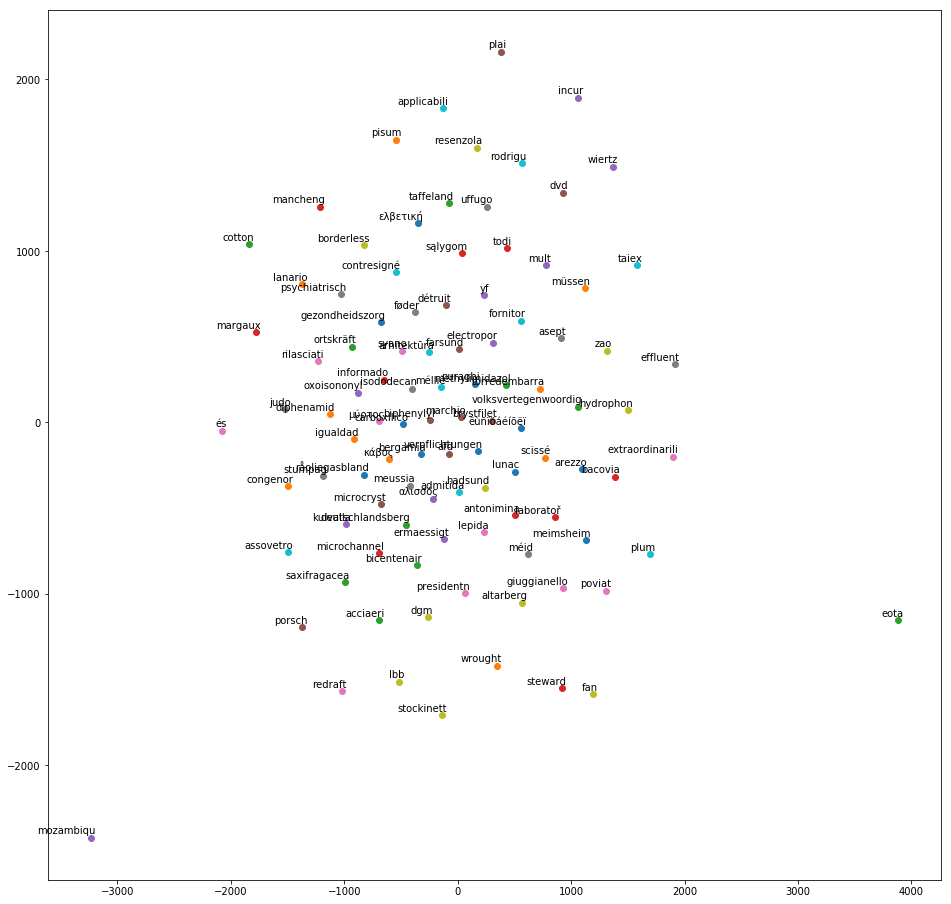

In [116]:
tsne_plot(model=model_w2v)

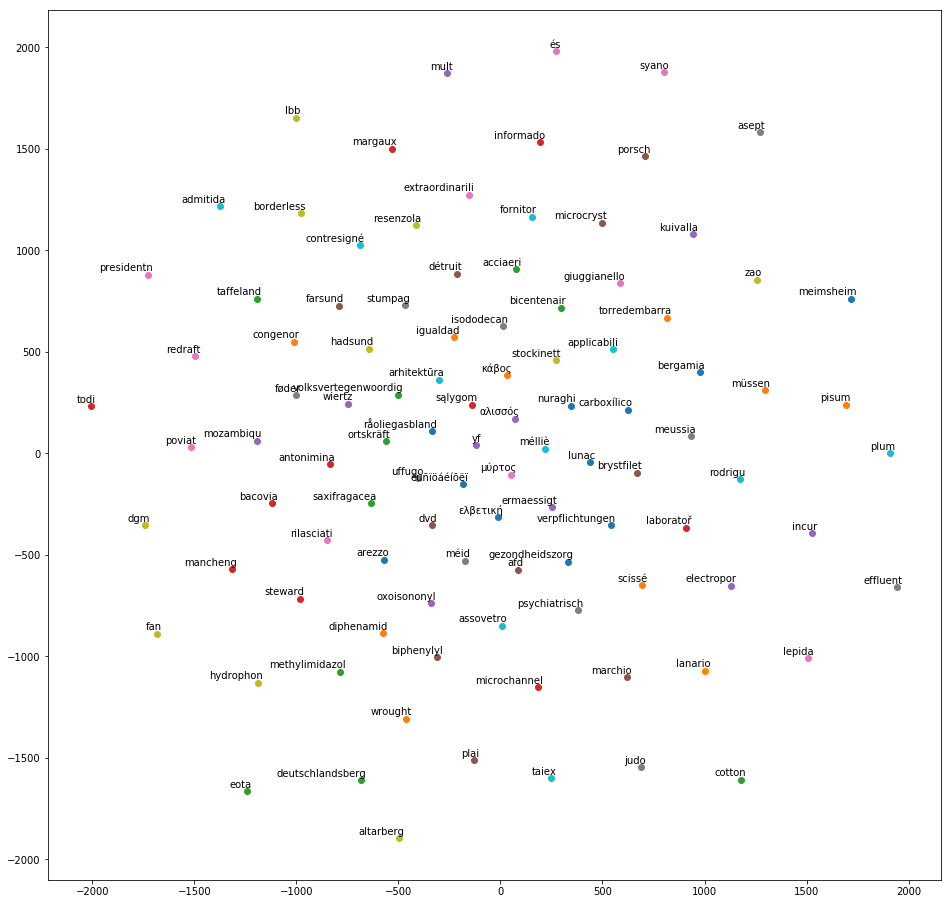

In [118]:
tsne_plot(model=model_ft)

In [100]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

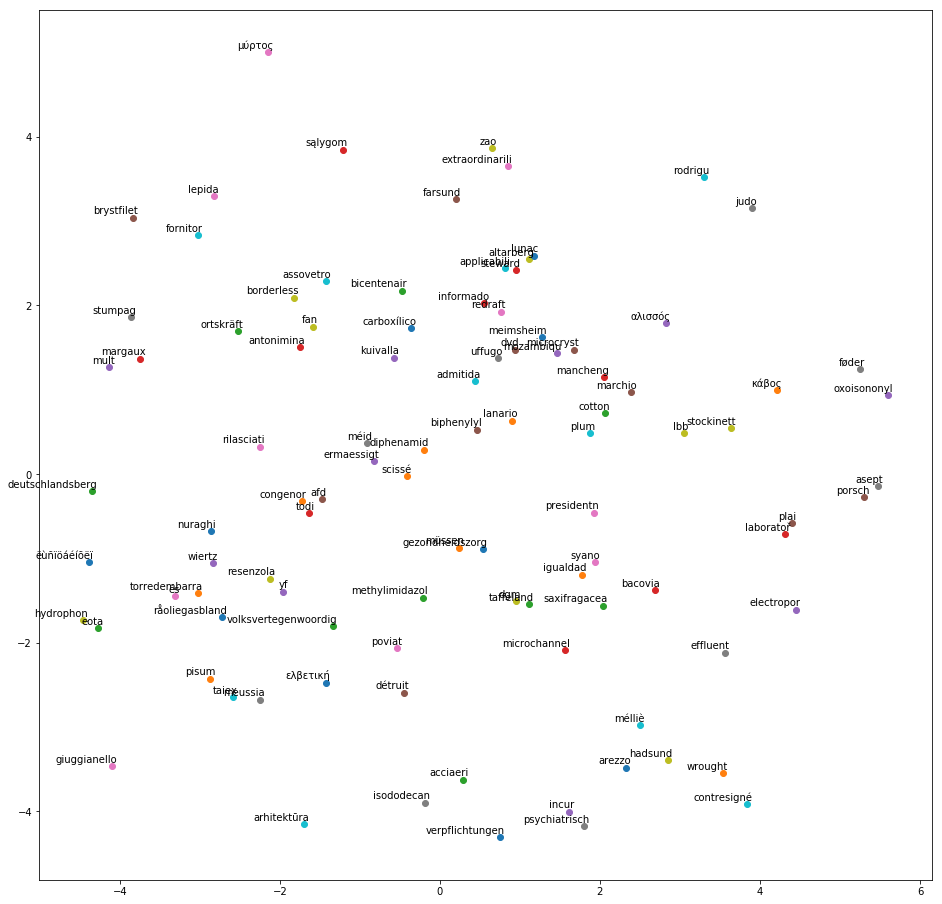

In [123]:
pca.fit(X_train2)
low_d_x = pca.transform(X_train2)

tsne_plot(model=model_w2v, new_values=low_d_x)

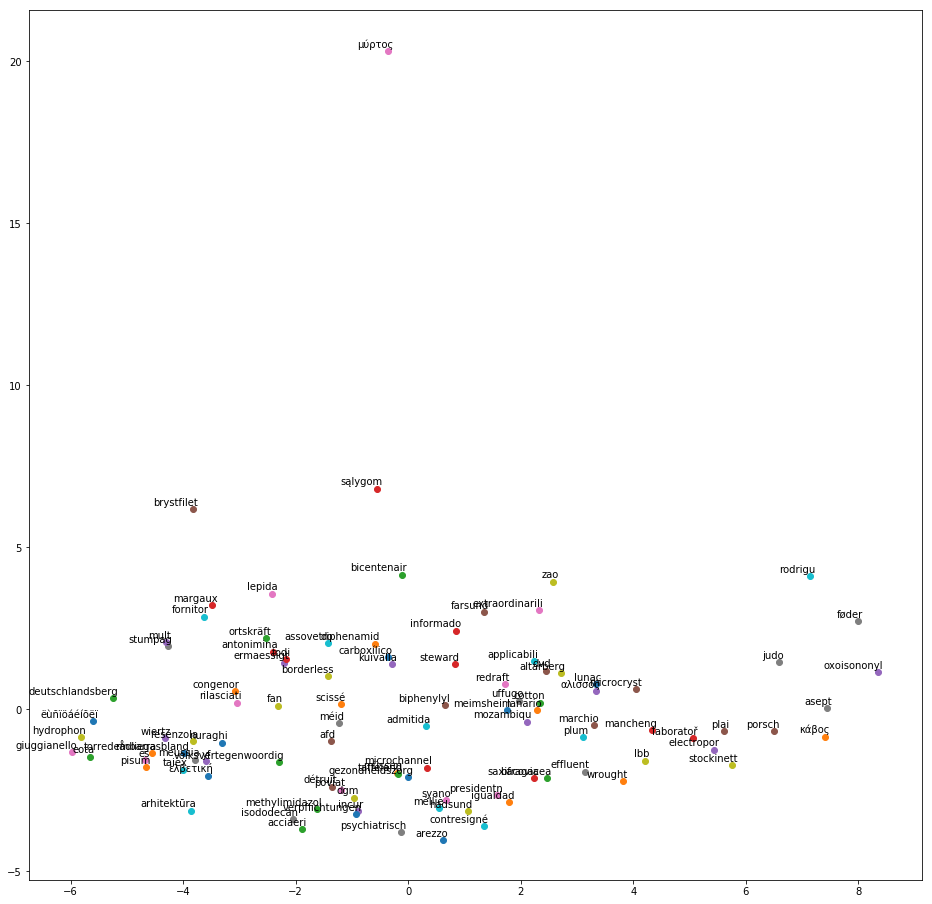

In [125]:
pca.fit(X_train3)
low_d_x = pca.transform(X_train3)

tsne_plot(model=model_ft, new_values=low_d_x)


In [137]:
# preparing data for tensorflow projection util

# w2v
tokens, labels = [], []

for i, word in enumerate(model_w2v.wv.vocab):
        tokens.append(model_w2v[word])
        labels.append(word)
        if i == 5000: break
            
with open('w2v.tsv', 'w') as f:
    res = ''
    for tok in tokens:
        res += '\t'.join([str(i) for i in tok]) + '\n'
    f.write(res)

with open('w2v_meta.tsv', 'w') as f:
    res = ''
    for l in labels:
        res += l + '\n'
    f.write(res)
    
# ft
tokens, labels = [], []

for i, word in enumerate(model_ft.wv.vocab):
        tokens.append(model_ft[word])
        labels.append(word)
        if i == 5000: break
            
with open('ft.tsv', 'w') as f:
    res = ''
    for tok in tokens:
        res += '\t'.join([str(i) for i in tok]) + '\n'
    f.write(res)

with open('ft_meta.tsv', 'w') as f:
    res = ''
    for l in labels:
        res += l + '\n'
    f.write(res)

In [134]:
# w2v tensorflow
url_w2v='https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/30mb1/320500f5753f2bc41110dac1416a78d6/raw/1c30f014ef92810ba71d896d9dcef4c4f11e1803/projector_config.json'
# ft tensorflow
url_ft='https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/30mb1/427f6269a7d6e2210e34557cb07e45eb/raw/78ea5c28cd7d2e739db46c47d4b86f9220e06c39/projector_config.json'
